# EDA Using Python and Bigquery
Performing simple EDA using python and accessing the data from Google Bigquery.

In this simple project, I'm going to do a simple exploratory data analysis using data from bigquery sandbox. The point of this project is to show how I can use the Google Bigquery as my data source in analysing data and to show how i can use the bigquery API in python.

The goals of this analysis is just to extact as many information from the available data without any specific goals detemined. First, we're going to import our necessary libaries and some setting up the API to access the google bigquery. To quickly query our data, we can also make some function to convert our query result into a pandas DataFrame to easily manipulate our queried data.

In [10]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import db_dtypes
from google.cloud import bigquery #Google bigquery API

# Directing to my Google cloud service account filepath to access data in our bigquery account
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'test-379712-425f276bd1f8.json'

client = bigquery.Client()
# Return query into a dataframe
def query_to_df(sql_query):
    return(client.query(sql_query).to_dataframe())

# Return schema as the columns info
def get_schema(table):
    return(client.get_table(table).schema)

In [11]:
# See columns info details to understand our data
table = 'bigquery-public-data.iowa_liquor_sales.sales'

tbl_main = get_schema(table)
tbl_main

[SchemaField('invoice_and_item_number', 'STRING', 'NULLABLE', None, 'Concatenated invoice and line number associated with the liquor order. This provides a unique identifier for the individual liquor products included in the store order.', (), None),
 SchemaField('date', 'DATE', 'NULLABLE', None, 'Date of order', (), None),
 SchemaField('store_number', 'STRING', 'NULLABLE', None, 'Unique number assigned to the store who ordered the liquor.', (), None),
 SchemaField('store_name', 'STRING', 'NULLABLE', None, 'Name of store who ordered the liquor.', (), None),
 SchemaField('address', 'STRING', 'NULLABLE', None, 'Address of store who ordered the liquor.', (), None),
 SchemaField('city', 'STRING', 'NULLABLE', None, 'City where the store who ordered the liquor is located', (), None),
 SchemaField('zip_code', 'STRING', 'NULLABLE', None, 'Zip code where the store who ordered the liquor is located', (), None),
 SchemaField('store_location', 'GEOGRAPHY', 'NULLABLE', None, 'Location of store who 

Looks like our table is an transaction column of every order that had been made. We might want take a glimpse of our data. But, due to the size of our data we are going to aggregate our data into daily order data so that the computation power is reduced.

In [236]:
q1 = """
SELECT date, SUM(sale_dollars) sales, 
SUM((state_bottle_retail-state_bottle_cost)*bottles_sold) as profit, 
SUM(bottles_sold) as bottles_sold, COUNT(*) as count_transc
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date BETWEEN '2022-01-01' AND '2022-12-31'
GROUP BY date
ORDER BY date
"""

df1 = query_to_df(q1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          307 non-null    dbdate 
 1   sales         307 non-null    float64
 2   profit        307 non-null    float64
 3   bottles_sold  307 non-null    Int64  
 4   count_transc  307 non-null    Int64  
dtypes: Int64(2), dbdate(1), float64(2)
memory usage: 12.7 KB


We can see that there's only 607 rows which means that it's not everyday that the stores ordered item to the state. Fortunately there's no null value(s).

Next, we are to see the descriptive statistics in each column and their distributions.

In [237]:
df1.describe()

,sales,profit,bottles_sold,count_transc
count,3.070000e+02,3.070000e+02,307.0,307.0
mean,1.396678e+06,4.666200e+05,99127.110749,8353.631922
std,6.852470e+05,2.289307e+05,47231.959739,3993.62424
min,1.710000e+02,5.700000e+01,3.0,1.0
25%,1.296942e+06,4.335989e+05,92009.0,7754.0
50%,1.576202e+06,5.287003e+05,113926.0,9686.0
75%,1.764993e+06,5.909329e+05,127554.5,10892.5
max,3.088637e+06,1.032305e+06,183890.0,18965.0


Right away we can tell that the distributions is vary and we might safely say that there's not many outlier in any columns. But, to test this we are going to check this later using IQR method.

Another thing that we can make out from this information is that all of the variable is a little left skewed which might means that there's some dependent variables. To clearly see the distribution we can make a visualization of each variables.

We might first want to analyze the most obvious thing for a sales data, it's sales. We are going to plot our daily sales distributions data per year. Our main focus is in year 2022.

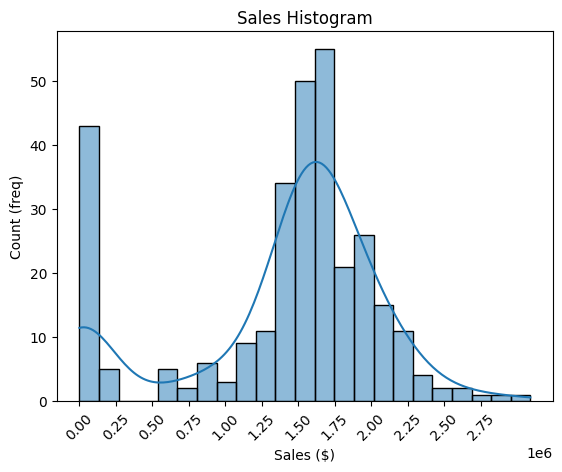

In [310]:
sns.histplot(df1.sales, kde=True)

x_ticks = list(np.arange(0,3000000,250000))
plt.xticks(x_ticks, rotation=45)
plt.xlabel('Sales ($)')
plt.ylabel('Count (freq)')
plt.title('Sales Histogram')
plt.show()

Our sales distibution is definitely not normal but there seems to be 2 groups of distibutions. One with sales below 500000-ish and the one below it. We might want to plot these two grops together so that we can see clearly their differences.

I'm also curious whether the date of the have any correlation with the two groups. Does peak season such as the end of the year means there's less days with lower sales? we might want to to this after we plot the two groups.

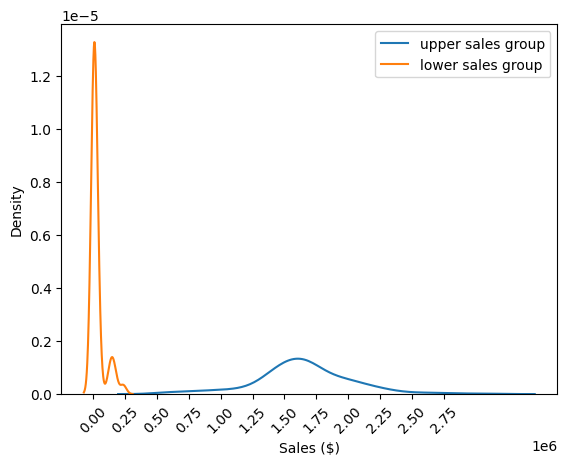

In [349]:
q2a = """
SELECT date, SUM(sale_dollars) sales
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date BETWEEN '2022-01-01' AND '2022-12-31'
GROUP BY date
HAVING sales > 500000
"""
upper_sales = query_to_df(q2a)

q2b = """
SELECT date, SUM(sale_dollars) sales
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date BETWEEN '2022-01-01' AND '2022-12-31'
GROUP BY date
HAVING sales <= 500000
"""
lower_sales = query_to_df(q2b)

sns.kdeplot(upper_sales['sales'], label='upper sales group')
sns.kdeplot(lower_sales['sales'], label='lower sales group')

x_ticks = list(np.arange(0,3000000,250000))
plt.xticks(x_ticks, rotation=45)
plt.xlabel('Sales ($)')
plt.ylabel('Density')
plt.legend()
plt.show()

In this plot we can clearly see that there is 2 distinct group of distribution, upper (blue) and lower (orange). The lower group seems to have lower variance than the upper group which makes it more interesting because our previous assumption about the correlation with the date might be true but to make sure of our assumption, we are going to present our data points in a timely manner then plot it using scatter plot.

To test this, what we're gonna do is to label these two groups and use some SQL data manipulation to make the data time-series so we can plot it in a timely manner.

Text(0.5, 1.0, 'Sales Order Plot by Sales Group')

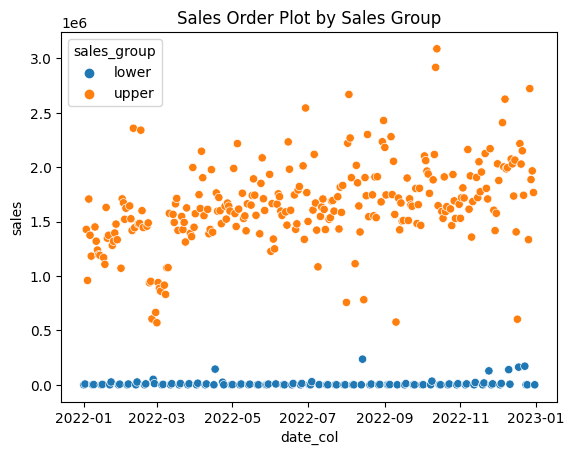

In [363]:
q3 = """
WITH date_range AS(
SELECT date_col
FROM UNNEST(GENERATE_DATE_ARRAY(DATE '2022-01-01', DATE '2022-12-31')) date_col
),

cte AS(
SELECT date, SUM(sale_dollars) sales
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date BETWEEN '2022-01-01' AND '2022-12-31'
GROUP BY date
ORDER BY date
)
SELECT date_col, sales, sales_group, 
SUM(sales) OVER (PARTITION BY sales_group ORDER BY date_col) cuml_sales_group,
COUNT(sales_group) OVER (PARTITION BY sales_group ORDER BY date_col) cuml_count_group
FROM(
    SELECT date_range.date_col, cte.sales,
    CASE
        WHEN cte.sales <= 500000 OR cte.sales IS NULL THEN 'lower'
        WHEN cte.sales > 500000 THEN 'upper'
    END sales_group
    FROM date_range
    LEFT JOIN cte
    ON date_range.date_col = cte.date
    ORDER BY date_range.date_col 
    )
ORDER BY date_col
"""
df_q3 = query_to_df(q3)
df_q3['sales'] = df_q3['sales'].fillna(0) 
df_q3 = df_q3.set_index('date_col')

sns.scatterplot(df_q3, x=df_q3.index, y='sales', hue='sales_group')
plt.title('Sales Order Plot by Sales Group')

It looks like there's no significant changes in lower sales frequency at the end of the year, where usually where the peak season is. This might make sense since our data is an transaction order record of stores in Iowa to the vendor through the state. Store might want to stock in preapare for a peak season in advance or some other reason. We might want to see the count of each sales group overtime and whether there's significant changes in number of lower/upper sales group. Using our previous query and some scaling so amplify the differences, we are going to plot our cumulative count of each sales group.

Text(0.5, 1.0, 'Cumulative Count of Each Sales Groups (Scaled)')

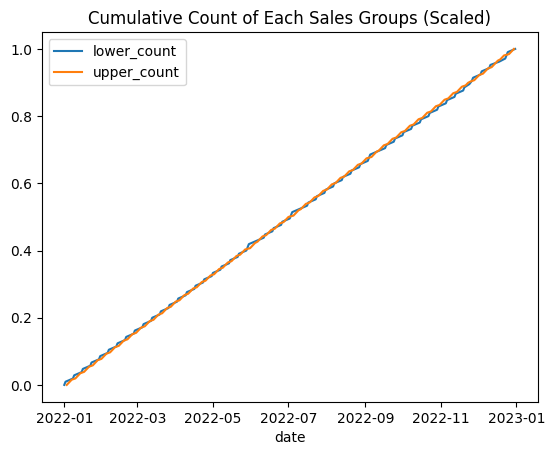

In [381]:
lower = df_q3['cuml_count_group'][df_q3['sales_group'] == 'lower']
scaled_lower = ((lower - lower.min()) / (lower.max() - lower.min()))
upper = df_q3['cuml_count_group'][df_q3['sales_group'] == 'upper']
scaled_upper = ((upper - upper.min()) / (upper.max() - upper.min()))
plt.plot(scaled_lower, label='lower_count')
plt.plot(scaled_upper, label='upper_count')

plt.xlabel('date')
plt.legend()
plt.title('Cumulative Count of Each Sales Groups (Scaled)')

Unfortunately, even when the data is scaled there seems to be no significant changes in the number of lower/upper sales happening throughout the year. This can conclude our previous assumption that there is no significant correlation between the time (date) and the changes of our daily sales order. To finally conclude our assumption, we can do some correlation test such as Pearson Correlation test to really make sure of our conclution.

In [382]:
from scipy.stats import pearsonr

day_count = list(np.arange(1,366,1))
df_q3['day_count'] = day_count

sales = df_q3['sales']
time = df_q3['day_count']
correlation_coefficient, p_value = pearsonr(sales, time)

print("Pearson correlation coefficient:", correlation_coefficient)
print("p-value:", p_value)

Pearson correlation coefficient: 0.14893520884145153
p-value: 0.004350478658837122


The Pearson Correlation Coefficient ranges from -1 to +1, 1 means perfect positive correlation and -1 means otherwise. Our test shows that we got around 0.14 as the coefficient value which translates to our variables not being significantly correlated either positive or negative. This result also verified by our p-value of less than 5% which means our data is statistically significant. This conclude our analysis and some points can be made from it:
1. Our daily sales order data can be made into 2 group of distributions, lower and upper sales group due to the differences in their distributions.
2. From dividing our data to these two groups, we can make a threshold of our order sales: daily sales below $500000 means that it's a low order sales and above it means it's and higher/upper sales group.
3. There is no correlation between the sales groups and the time so there might be other reasoning behind it.

We may continue our data exploration but for now we can use the information we can make out from our data.